# IMPROVE MODEL WITH DATA-AUGMENTATION

* trainset의 분포가 부족한 라벨에 대해 pseudo-labeling을 이용해 데이터 증강을 적용한 모델

* 기존성능평가를 통해 가장 성능이 낮으면서 분포가 부족한 공통부분인 1.8-3.2구간의 데이터만 증강 

In [10]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
# ! pip install sentence-transformers datasets

In [13]:
import numpy as np
import pandas as pd
import math
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryAccuracyEvaluator, CEBinaryClassificationEvaluator

from sentence_transformers.readers import InputExample




from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# 시드고정 
import torch
import random
import torch.backends.cudnn as cudnn


seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [15]:
model_save_path = "/home/sol3sts/removed_mean_cross_encoder_" + "-" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [16]:
# 학습경과 모니터링하는 logger 초기화
from importlib import reload
reload(logging)

logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG,
    handlers=[LoggingHandler()],
)

In [17]:
logging.info('This is an info message')

2022-12-20 18:35:15 - This is an info message


### Make Pseudo-labeled dataset

In [78]:
# 기학습된 모델로 pseudo-label 달아주기 
cross_encoder = CrossEncoder('/home/sol3sts/cross_encoder_base_model_-2022-12-12_04-11-33') # 증강전 데이터셋으로 학습된 모델 

### korsts - test

In [79]:
# korsts_test = pd.read_csv('/home/sol3sts/dataset/sts-test.tsv',sep="\t",error_bad_lines=False )
korsts_test = korsts_test.dropna()

korsts_all = korsts_test
korsts_all = korsts_all.reset_index()
korsts_all = korsts_all[['sentence1','sentence2']]
print(len(korsts_test))
korsts_all

1376


,sentence1,sentence2
0,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.
1,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.
2,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.
3,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.
4,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.
...,...,...
1371,필리핀과 캐나다는 더 나아가 관계를 증진시키겠다고 약속한다.,필리핀은 여객선 침몰 후 100명을 구한다.
1372,이스라엘은 팔레스타인인의 예루살렘의 구 시가지 출입을 금지한다.,팔레스타인인과 이스라엘 두 국가 해결안은 그림의 떡
1373,비밀경호국에 대해 얼마나 알고 계십니까?,양측 의원들은 비밀경호국에 분노를 표출한다
1374,이란 회담이 재개되면서 오바마는 사우디의 두려움을 달래기 위해 고군분투하고 있다.,미얀마는 일요일 투표를 위한 유권자 명단을 확정하기 위해 고군분투하고 있다.


In [80]:
# unlabled data prediction with best model
pairs_korsts = list(zip(korsts_all['sentence1'], korsts_all['sentence2']))

scores_korsts = cross_encoder.predict(pairs_korsts, show_progress_bar=True)

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

In [81]:
#korsts전체 klue로 학습한 모델로 pseudo_label해주기
korsts_all['labels.label'] = np.round((scores_korsts*5).tolist(),1)
korsts_all

,sentence1,sentence2,labels.label
0,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.,3.6
1,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.,4.3
2,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.,3.6
3,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.,4.7
4,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.,4.0
...,...,...,...
1371,필리핀과 캐나다는 더 나아가 관계를 증진시키겠다고 약속한다.,필리핀은 여객선 침몰 후 100명을 구한다.,0.7
1372,이스라엘은 팔레스타인인의 예루살렘의 구 시가지 출입을 금지한다.,팔레스타인인과 이스라엘 두 국가 해결안은 그림의 떡,1.1
1373,비밀경호국에 대해 얼마나 알고 계십니까?,양측 의원들은 비밀경호국에 분노를 표출한다,1.4
1374,이란 회담이 재개되면서 오바마는 사우디의 두려움을 달래기 위해 고군분투하고 있다.,미얀마는 일요일 투표를 위한 유권자 명단을 확정하기 위해 고군분투하고 있다.,0.5


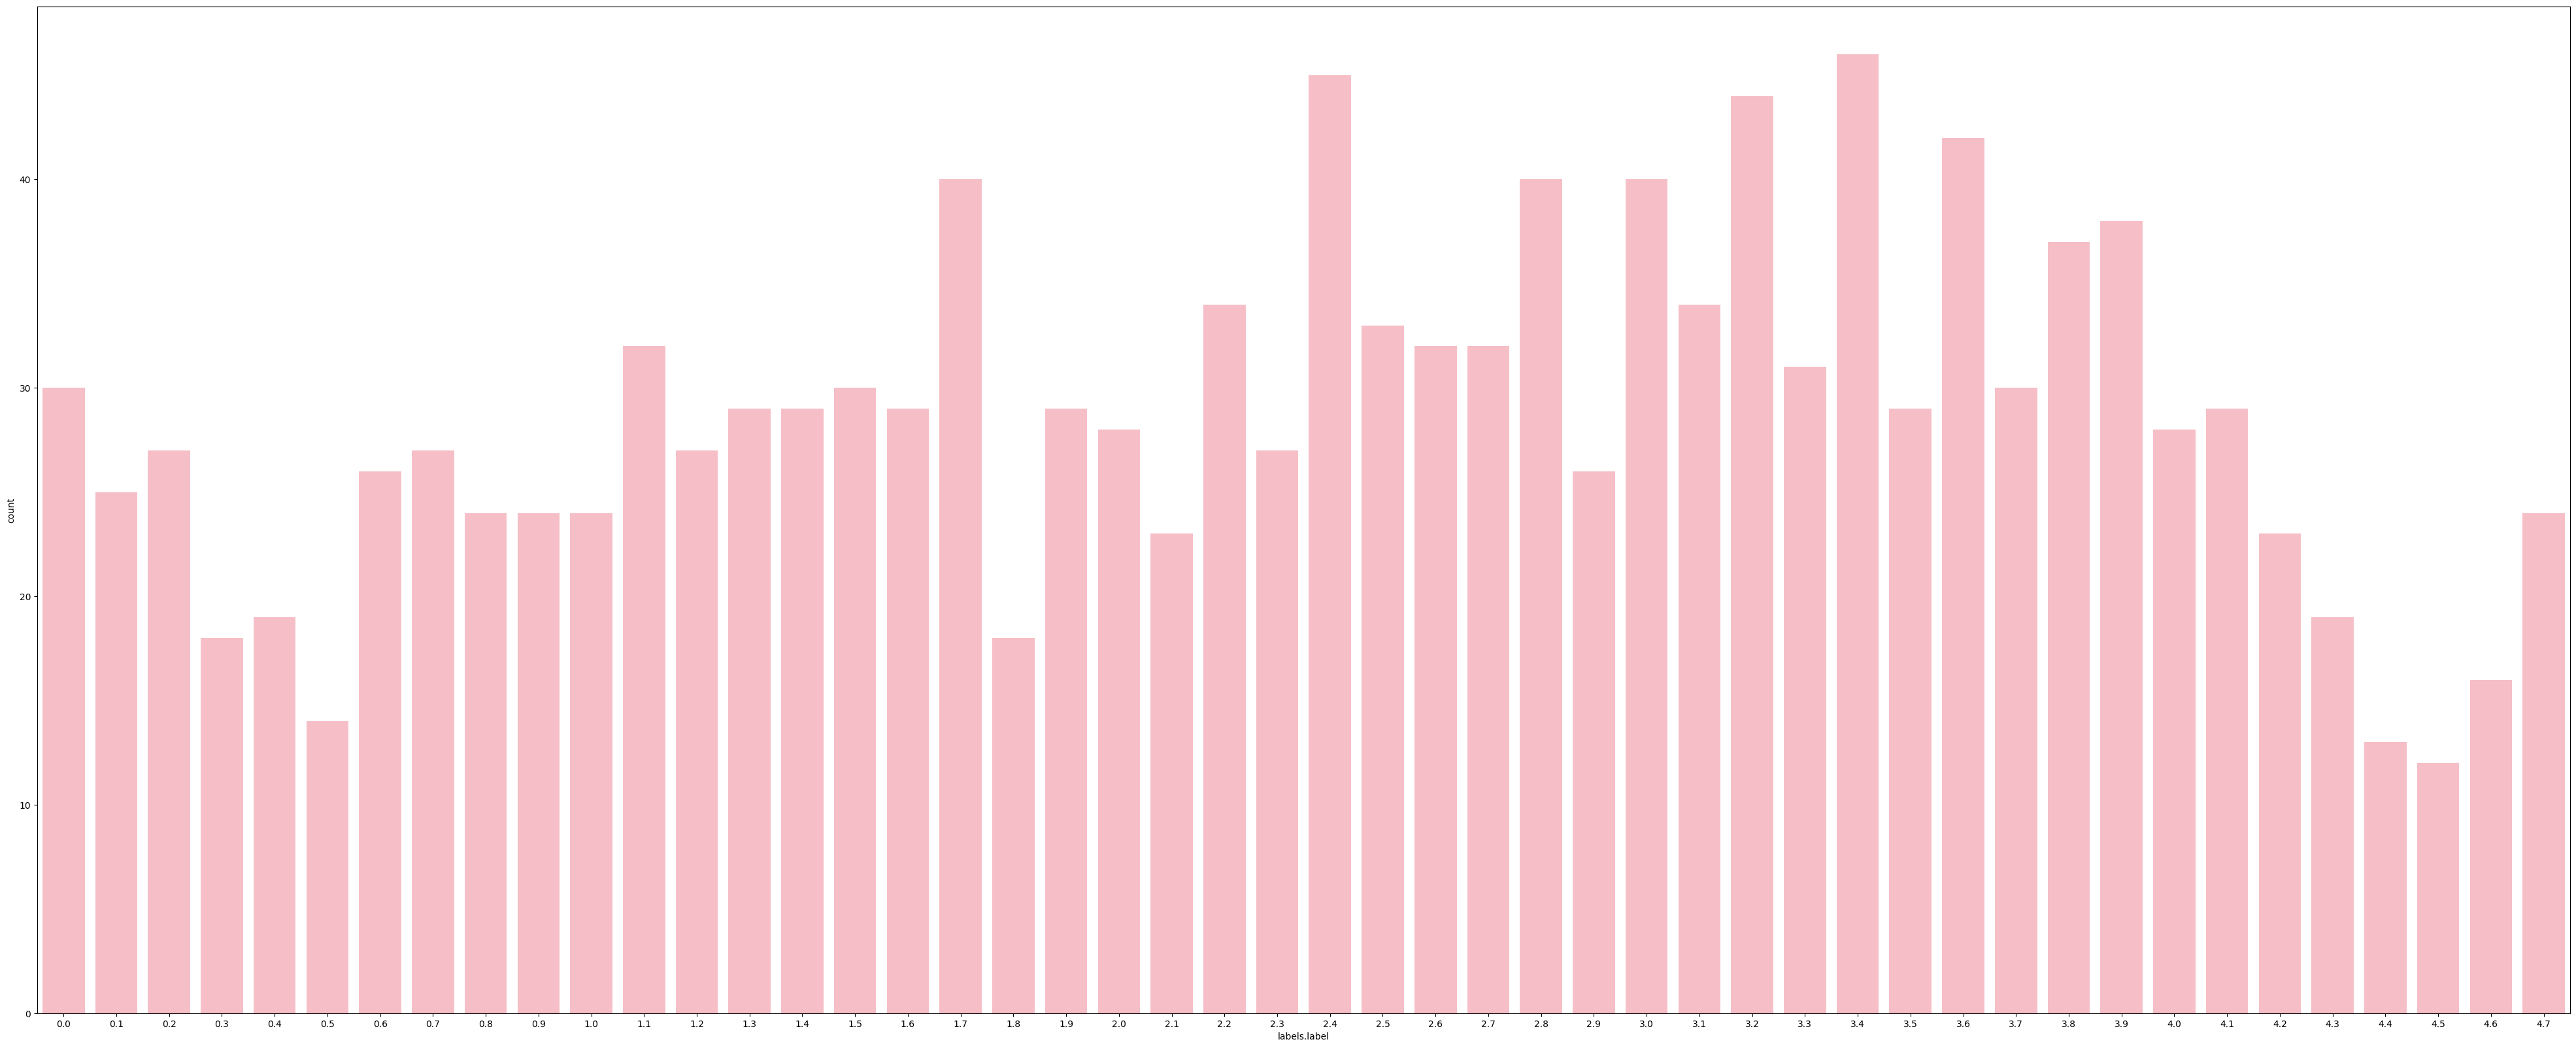

In [82]:
# 분포 확인하기 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(50,20))


sns.countplot(x = korsts_all['labels.label'],color='#FFB6C1')


plt.show()

In [83]:
# 1.8 - 3.2데이터만 추출 
aug_korsts = korsts_all[(korsts_all['labels.label'] >= 1.8) & (korsts_all['labels.label'] <= 3.2)]
aug_korsts

,sentence1,sentence2,labels.label
9,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.,2.5
10,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.,2.5
12,한 남자가 자전거를 타고 있다.,한 남자가 말하고 있다.,2.8
24,한 남자가 양파를 자르고 있다.,한 여성이 호박을 썰고 있다.,2.6
28,한 남자가 말하고 있다.,한 남자가 요리를 하고 있다.,2.6
...,...,...,...
1355,텍사스 공장 폭발로 100명 이상이 부상당했다.,수백 명의 사람들이 텍사스 비료 공장 폭발로 부상당한 것으로 추정된다.,2.9
1358,보도에 따르면 남한 군인은 북한과의 국경에서 5명의 동지들을 살해한 후 도망친다고 한다.,남한 군인이 동지들을 죽이고 도망친다.,2.6
1362,아프가니스탄의 무장 공격으로 상부에서 4명이 사망했다.,아프가니스탄의 무장 공격으로 발로치스탄에서 FC 병사가 사망했다.,2.6
1363,아프가니스탄 테러로 13명 사망,아프가니스탄 수도 모스크 공격으로 6명 사망,3.2


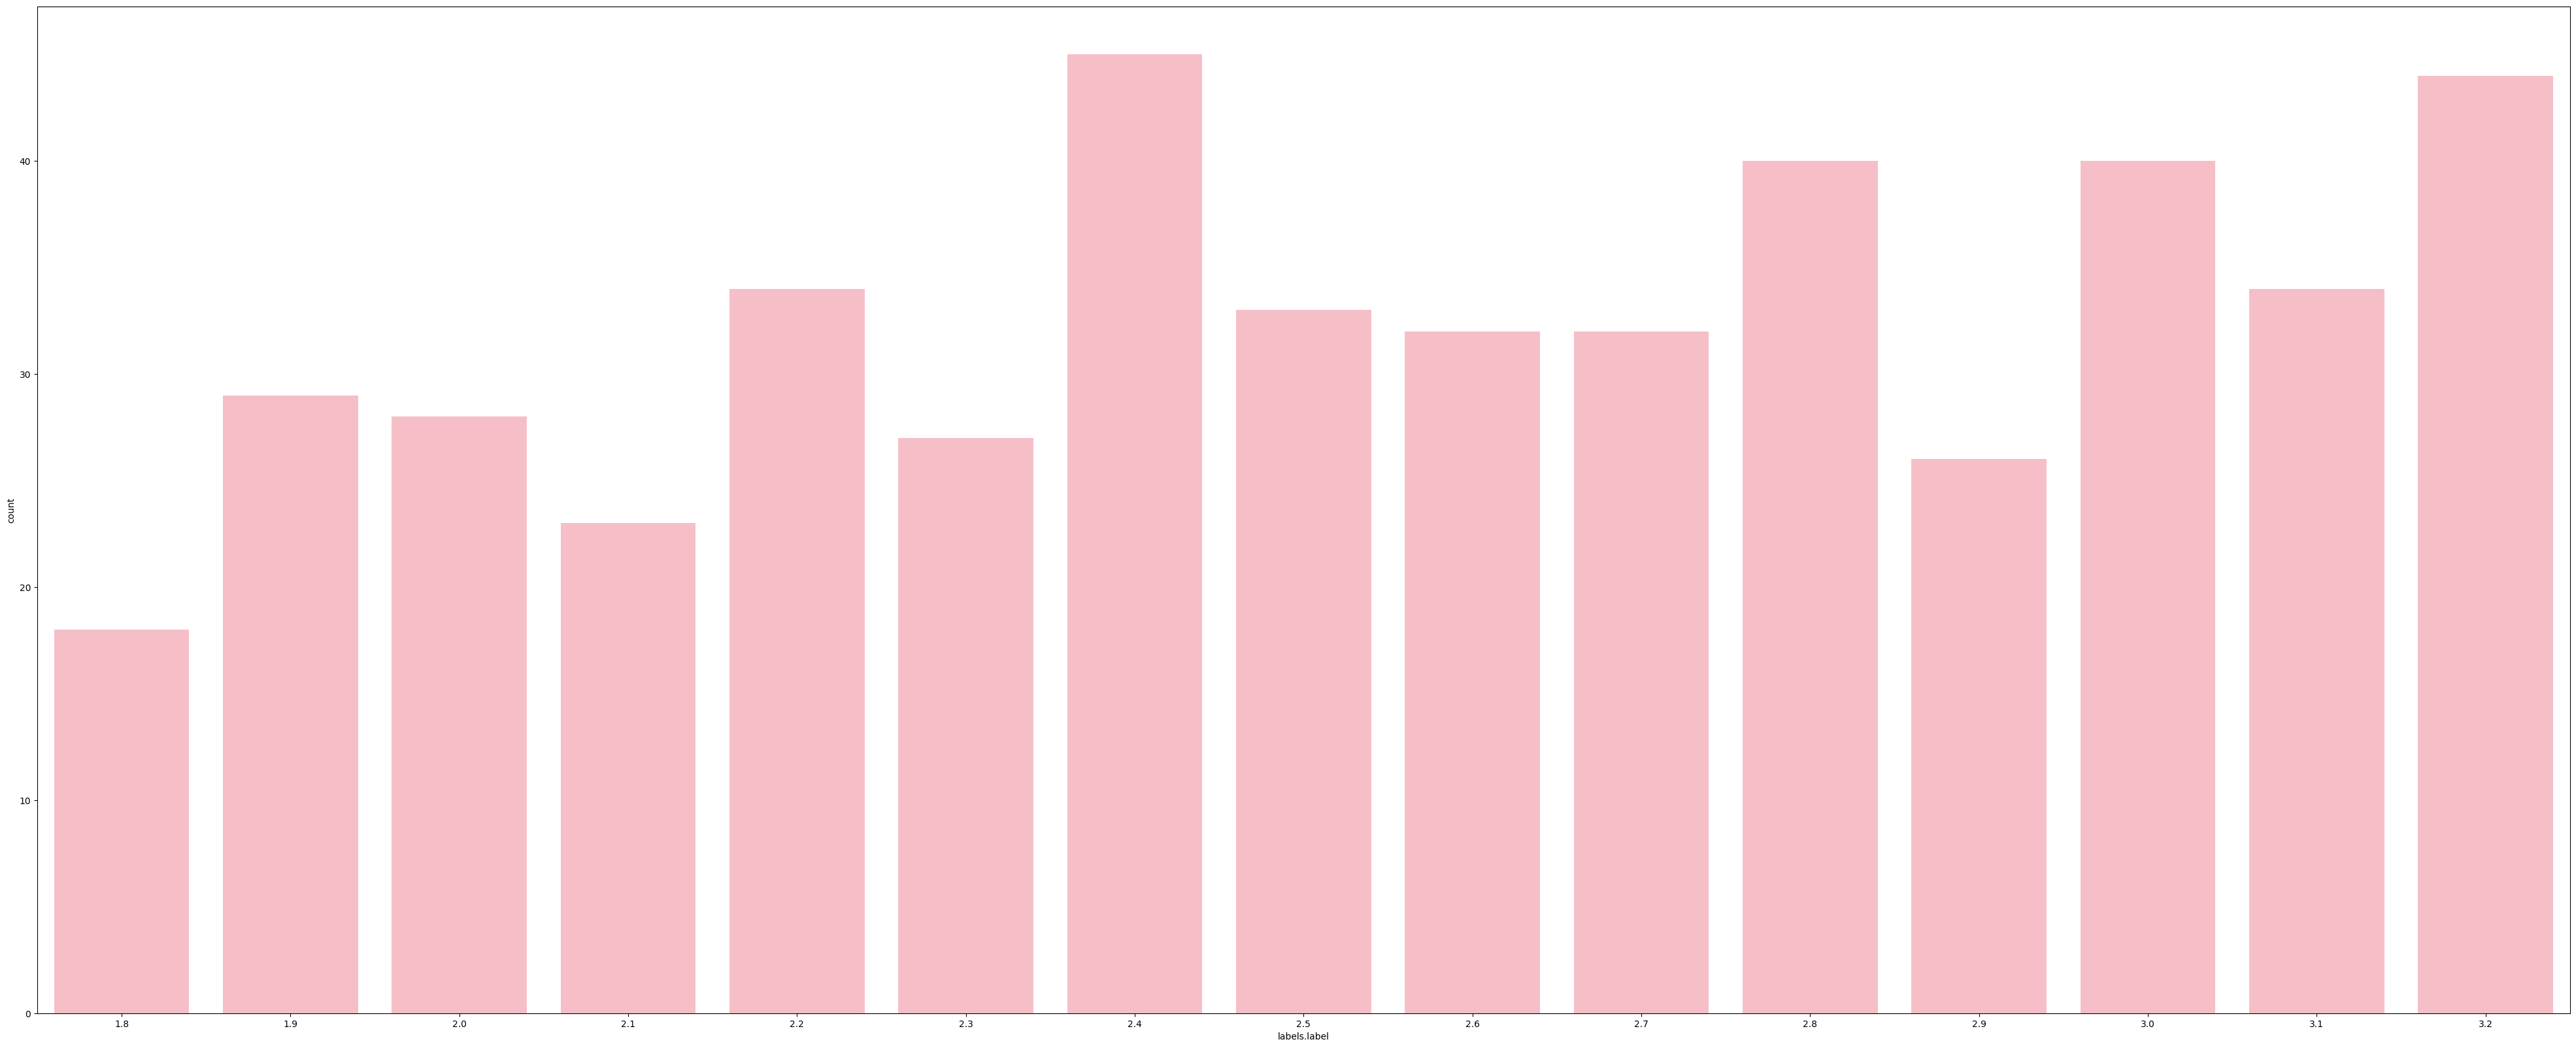

In [84]:
# 1.8-3.2 분포 확인하기 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(50,20))


sns.countplot(x = aug_korsts['labels.label'],color='#FFB6C1')


plt.show()

### 엑소브레인 패러프레이즈 말뭉치 데이터

In [85]:
# para_KAIST = pd.read_csv('/home/sol3sts/dataset/패러프레이즈 말뭉치 배포용_v1_181118.xlsx - Sheet1.csv')

para_KAIST.rename(columns = {'원문장':'sentence1'}, inplace=True)
para_KAIST.rename(columns = {'페러프레이즈 문장':'sentence2'}, inplace=True)
para_KAIST.rename(columns = {'유사성 점수':'labels.label'}, inplace=True)

para_KAIST = para_KAIST[['sentence1','sentence2']]

In [86]:
para_KAIST

,sentence1,sentence2
0,"남성은 50%가 블랙 색상을, 여성은 60%가 퍼플 색상을 선택했다.","남성은 50%가 블랙, 여성은 60%가 퍼플 색상을 선택했다."
1,데이터 주고받기·쉐어링·테더링을 모두 포함한 ‘나눠쓰기 데이터’ 한도를 업계 최대 ...,데이터 주고받기·쉐어링·테더링을 모두 포함한 ‘나눠쓰기 데이터’ 한도를 월 40GB...
2,"빈소는 신촌세브란스병원, 발인은 8일 오전 8시 30분.","빈소는 연세대세브란스병원, 발인은 8일 오전 8시30분이다."
3,30대 남성은 전체 고객 가운데 30%를 차지해 갤럭시S9 대표 고객군으로 파악됐다.,30대 남성은 전체 고객 가운데 30%를 차지해 갤럭시S9 대표 구매군으로 파악됐다.
4,"바다의 물결은 서해와 남해 먼바다에서 0.5∼2.0ｍ, 동해 먼바다에서 1.0∼3....","바다의 물결은 서해와 남해 먼바다 0.5∼2.0ｍ, 동해 먼바다 1.0∼3.0ｍ로 ..."
...,...,...
2067,결국 A씨는 부당해고를 인정받아 복직하고 해고 기간 임금을 받았다.,"결국 꿈에 그리던 루지 국가대표로 뽑혔고, 98년 나가노 올림픽에 출전해 31위를 했다."
2068,그 위력은 논리의 어긋남을 무시할 만큼 강력하다.,그 은은함을 대표하는 기상현상 중에 달무리가 있다.
2069,이는 9년 후부터는 우리나라 인구가 줄어들게 된다는 의미다.,이는 1991년 현행 가사소송법이 만들어진 지 27년 만에 이뤄지는 '첫 전면 개정...
2070,"다만 작가회의에서 할 수 있는 징계가 자격정지, 제명뿐""이라고 설명했다.",역동성과 세련미를 강조했다는 게 도요타 관계자의 설명이다.


In [87]:
# unlabled data prediction with best model
pairs_paraKAIST = list(zip(para_KAIST['sentence1'], para_KAIST['sentence2']))

scores_paraKAIST = cross_encoder.predict(pairs_paraKAIST, show_progress_bar=True)

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

In [88]:
#klue로 학습한 모델로 silver_label해주기
para_KAIST['labels.label'] = np.round((scores_paraKAIST*5).tolist(),1)
para_KAIST

,sentence1,sentence2,labels.label
0,"남성은 50%가 블랙 색상을, 여성은 60%가 퍼플 색상을 선택했다.","남성은 50%가 블랙, 여성은 60%가 퍼플 색상을 선택했다.",4.7
1,데이터 주고받기·쉐어링·테더링을 모두 포함한 ‘나눠쓰기 데이터’ 한도를 업계 최대 ...,데이터 주고받기·쉐어링·테더링을 모두 포함한 ‘나눠쓰기 데이터’ 한도를 월 40GB...,4.0
2,"빈소는 신촌세브란스병원, 발인은 8일 오전 8시 30분.","빈소는 연세대세브란스병원, 발인은 8일 오전 8시30분이다.",4.7
3,30대 남성은 전체 고객 가운데 30%를 차지해 갤럭시S9 대표 고객군으로 파악됐다.,30대 남성은 전체 고객 가운데 30%를 차지해 갤럭시S9 대표 구매군으로 파악됐다.,4.5
4,"바다의 물결은 서해와 남해 먼바다에서 0.5∼2.0ｍ, 동해 먼바다에서 1.0∼3....","바다의 물결은 서해와 남해 먼바다 0.5∼2.0ｍ, 동해 먼바다 1.0∼3.0ｍ로 ...",4.5
...,...,...,...
2067,결국 A씨는 부당해고를 인정받아 복직하고 해고 기간 임금을 받았다.,"결국 꿈에 그리던 루지 국가대표로 뽑혔고, 98년 나가노 올림픽에 출전해 31위를 했다.",0.1
2068,그 위력은 논리의 어긋남을 무시할 만큼 강력하다.,그 은은함을 대표하는 기상현상 중에 달무리가 있다.,0.1
2069,이는 9년 후부터는 우리나라 인구가 줄어들게 된다는 의미다.,이는 1991년 현행 가사소송법이 만들어진 지 27년 만에 이뤄지는 '첫 전면 개정...,0.0
2070,"다만 작가회의에서 할 수 있는 징계가 자격정지, 제명뿐""이라고 설명했다.",역동성과 세련미를 강조했다는 게 도요타 관계자의 설명이다.,0.0


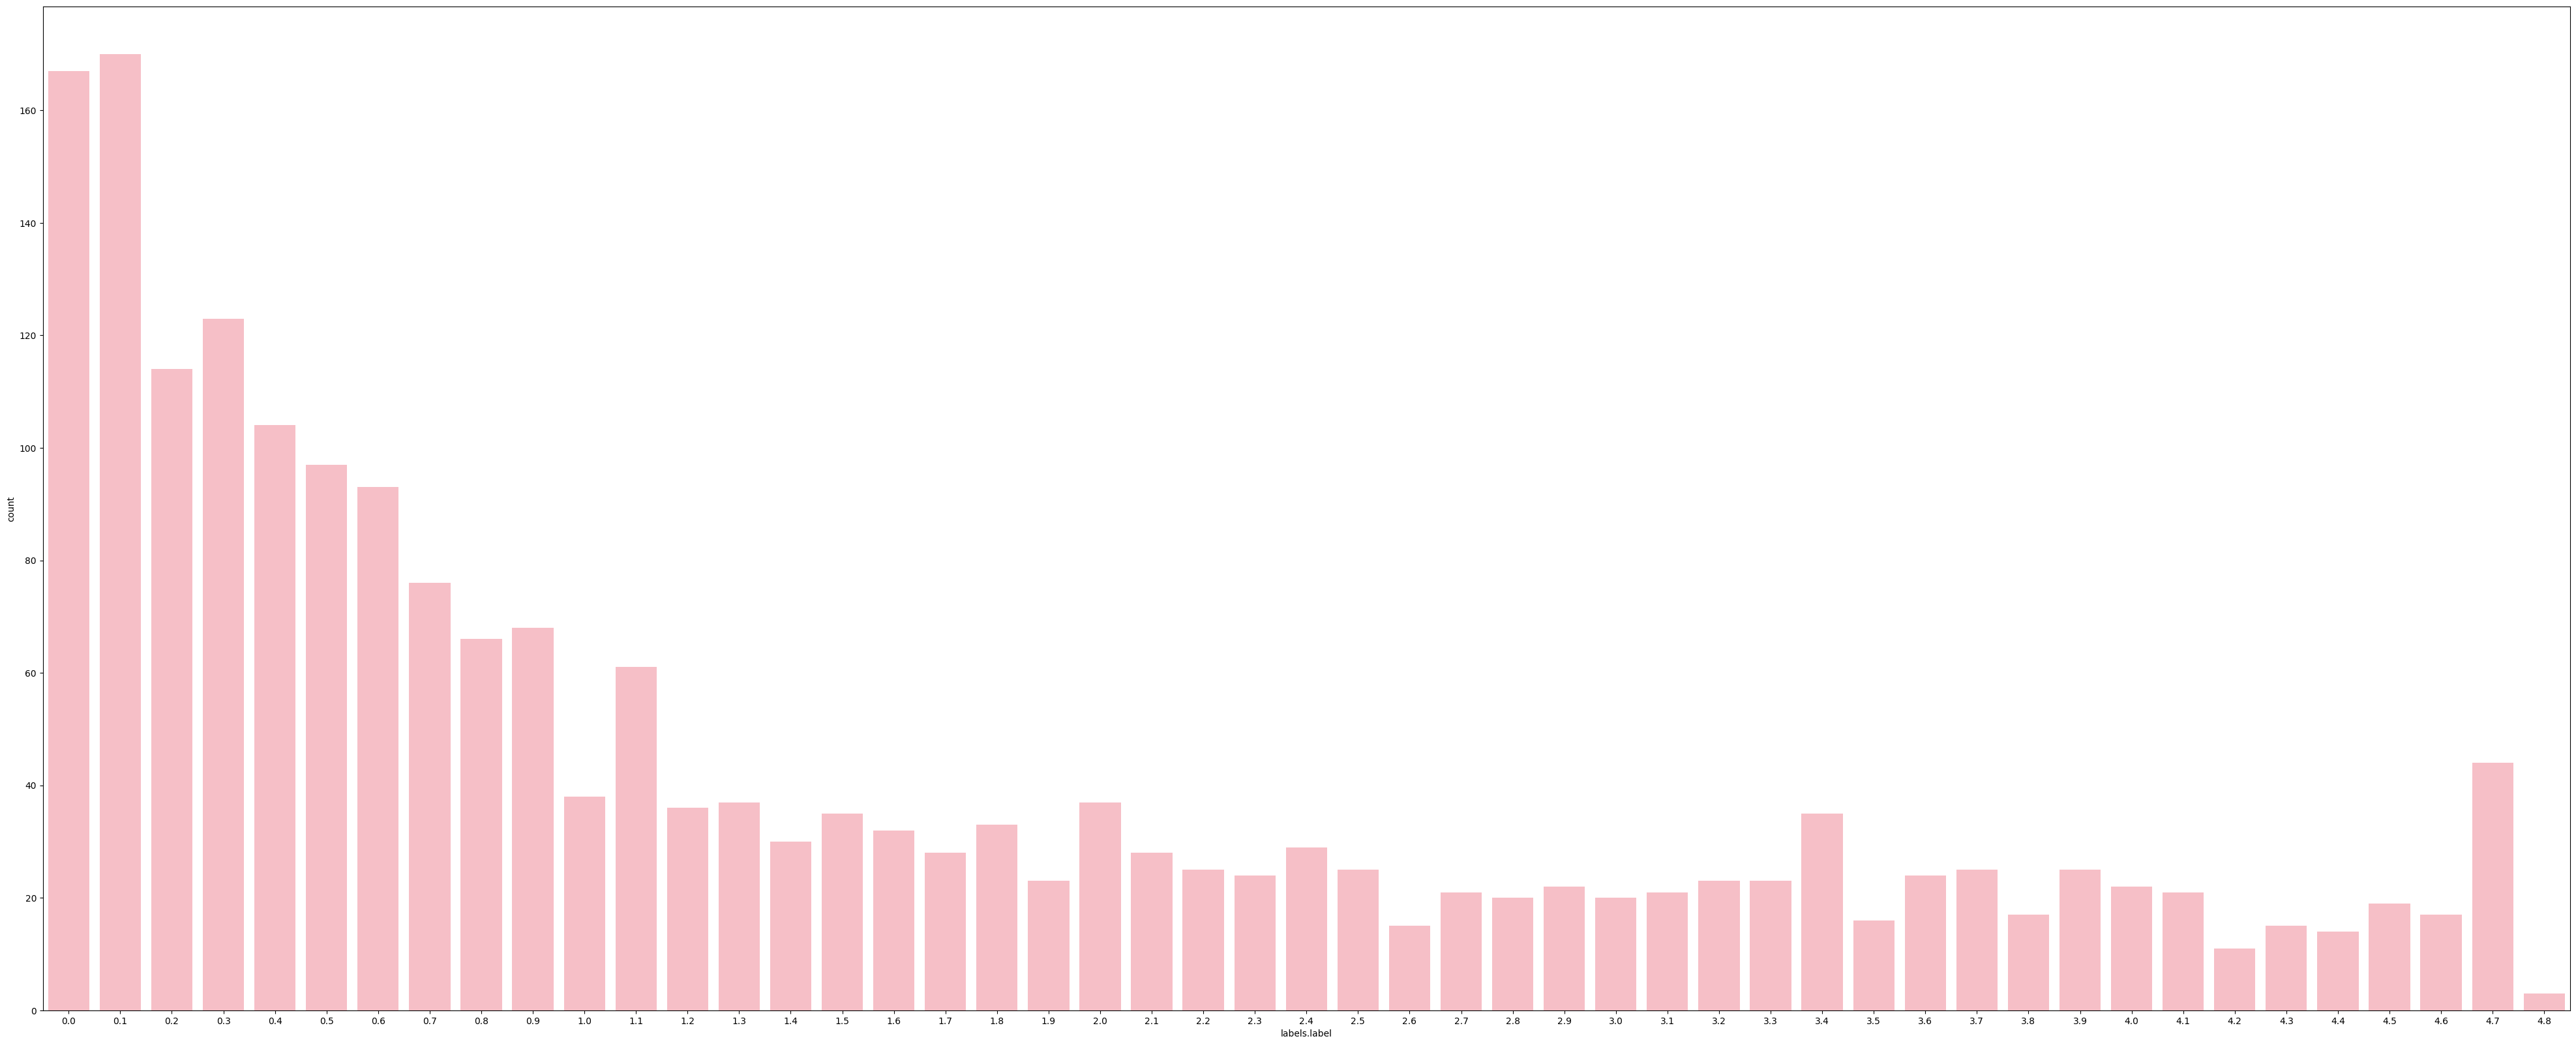

In [89]:
# 분포 확인하기 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(50,20))


sns.countplot(x = para_KAIST['labels.label'],color='#FFB6C1')


plt.show()

In [90]:
# 1.8 - 3.2데이터만 추출 
aug_paraKAIST = para_KAIST[(para_KAIST['labels.label'] >= 1.8) & (para_KAIST['labels.label'] <= 3.2)]
aug_paraKAIST

,sentence1,sentence2,labels.label
13,홍선주는 21일 자신의 페이스북에 '뉴스룸' 인터뷰를 한 사람이 자신이라고 공개했다.,"홍선주는 21일 자신의 페이스북에 ""접니다. JTBC '뉴스룸' 손석희 씨와 전화 ...",2.9
19,다음은 이윤택 전 연희단거리패 예술감독의 사과문 전문이다.,다음은 이윤택 전 예술감독이 밝힌 사과문 전문과 1문 1답 전문이다.,3.2
34,9일 강원도 평창올림픽스타디움에서 열린 평창동계패럴림픽 개막식에서 문재인 대통령이 ...,9일 강원도 평창 올림픽스타디움에서 2018 평창 동계패럴림픽 개회식이 열리고 있다.,3.1
48,사람들을 만나기에 좋은 날이에요.,대인운이 좋으니 사람을 만나기에 좋은 날입니다.,3.0
73,나도 당했다) 폭로를 통해 뒤늦게 알려졌다.,나도 당했다) 폭로가 이어지고 있다.,2.8
...,...,...,...
1501,꺼림칙한 사람이나 불필요한 자리는 피하도록 하세요.,되도록 많은 사람들이 모이는 자리에 빠지지 않도록 하세요.,2.1
1625,내키지 않는 모임도 피하도록 하세요.,지나친 고집은 피하도록 하세요.,2.0
1665,낙동강물을 사용하면 원수 대금뿐만 아니라 물이용 부담금을 따로 내야 한다.,원수 대금과 물이용 부담금도 없었다.,2.3
1721,평창패럴림픽 개막일인 9일 오전 강원 평창군 일대에 긴급 제설작전이 펼쳐졌다.,2018 평창동계패럴림픽 개막일인 9일 오전 강원도 평창 바이애슬론센터에서 선수들이...,2.2


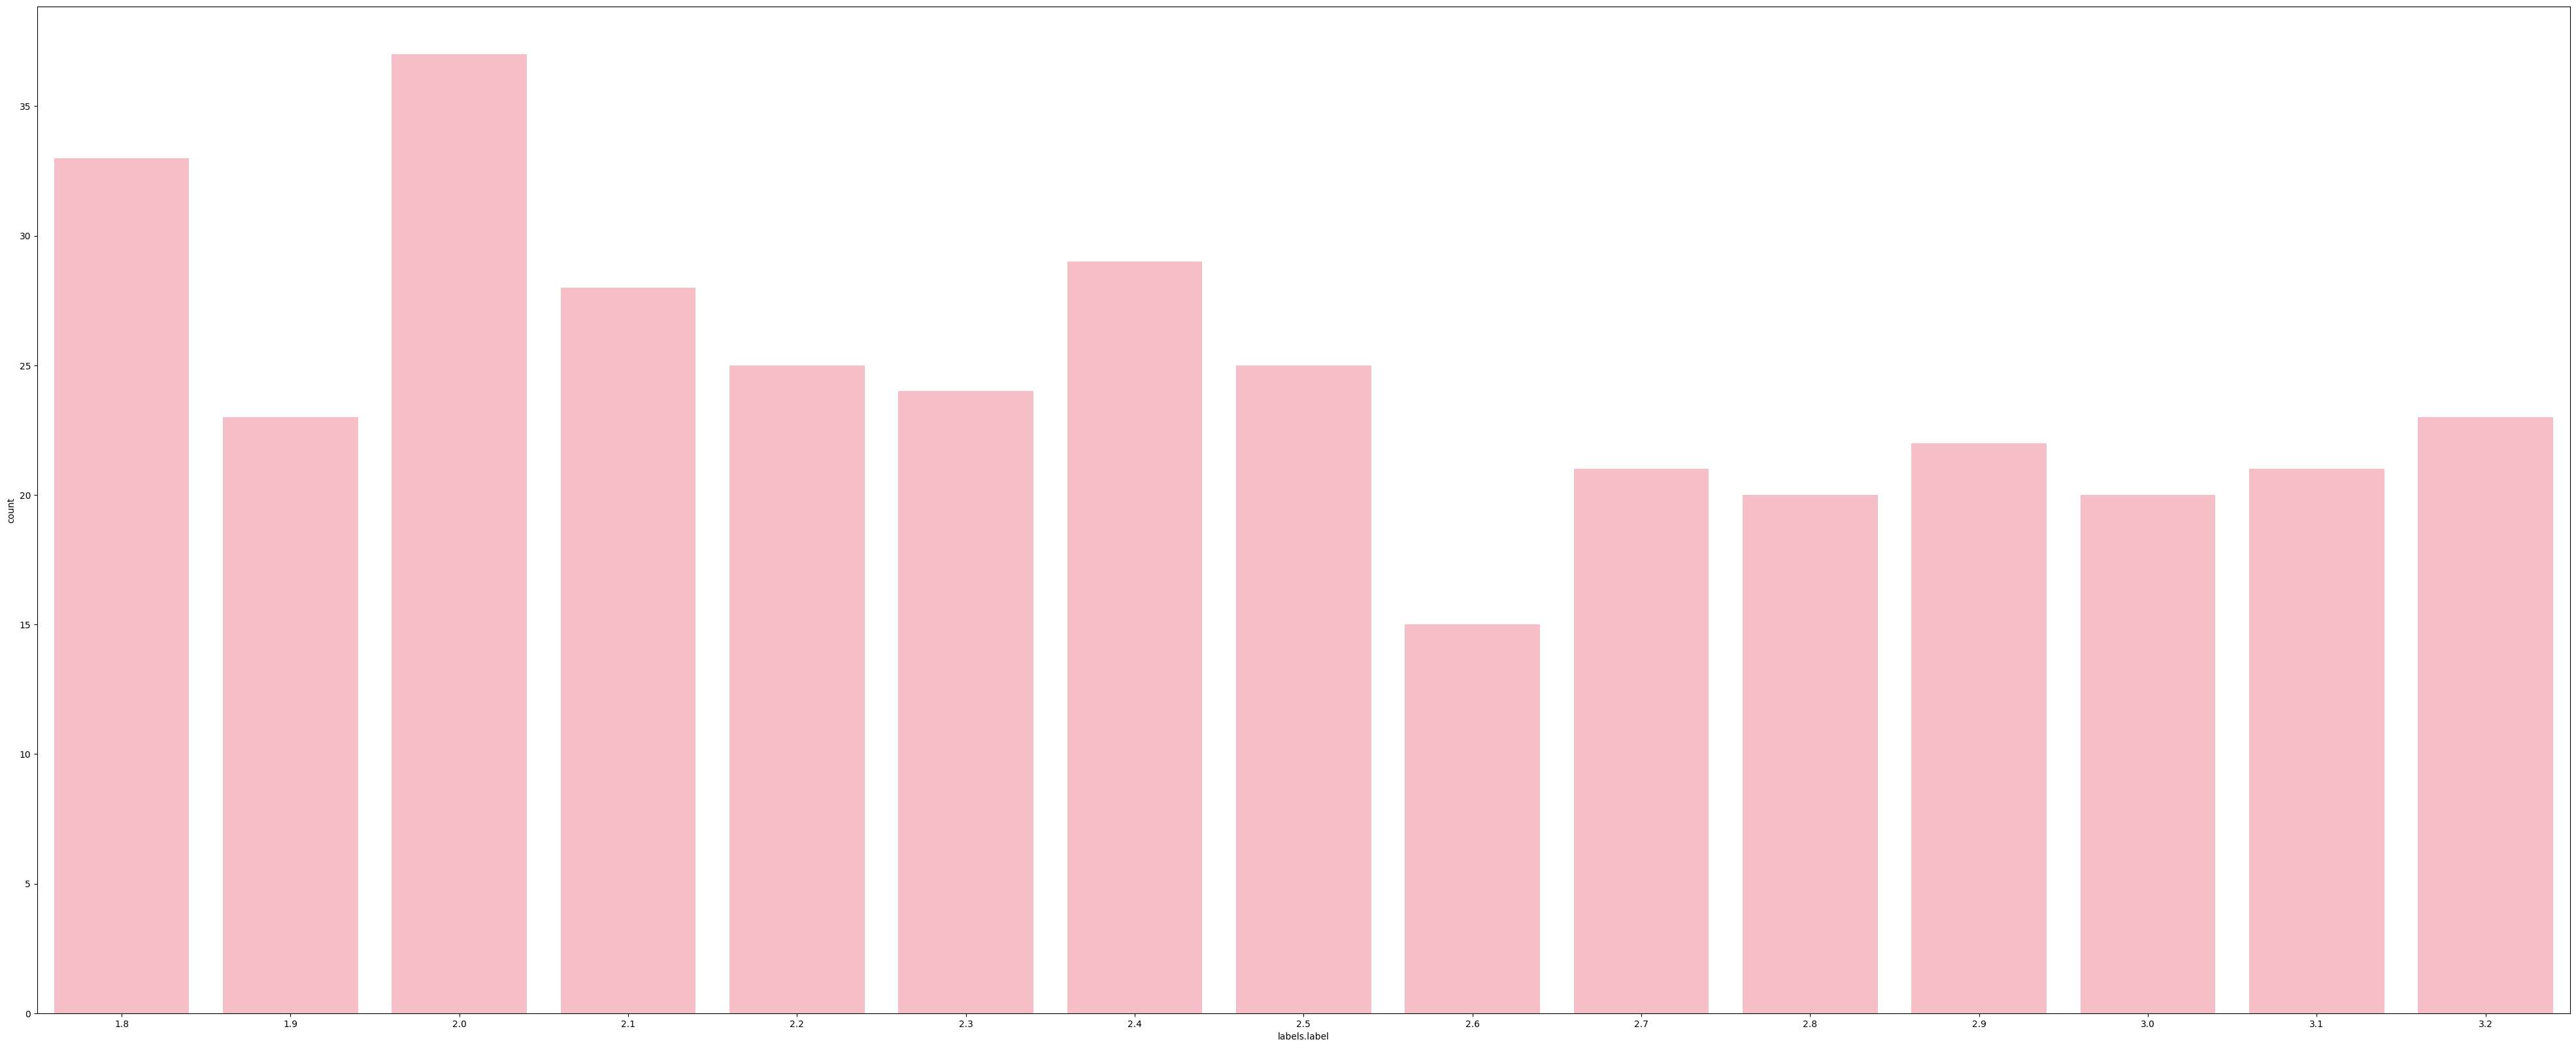

In [91]:
# 1.8-3.2분포 확인하기 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(50,20))


sns.countplot(x = aug_paraKAIST['labels.label'],color='#FFB6C1')


plt.show()

### Load Model

cross-encoder

In [18]:
# 새로운 모델 학습시 모델 초기화

from sentence_transformers.cross_encoder import CrossEncoder

cross_encoder = CrossEncoder("klue/roberta-base", num_labels=1)

num_epochs=3
train_batch_size = 32

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classif

### Load Data (KLUE-STS)

###  새로운 데이터 로드

In [25]:
train = pd.read_csv('/home/sol3sts/dataset/1209_train_dev&val제거.csv')
val = pd.read_csv('/home/sol3sts/dataset/1209_val.csv')
eval = pd.read_csv('/home/sol3sts/dataset/new_devset.csv')

In [26]:
len(train),len(val),len(eval)

(10992, 638, 557)

In [27]:
eval= eval[['sentence1','sentence2','new_label']]
test = eval.rename(columns={'new_label':'labels.label'})


### 새로운 데이터 (new_label)로 데이터 로드 

In [28]:
# 새로운 데이터로 학습 
train = train.reset_index()
train = train[['sentence1','sentence2','new_label']]
train = train.rename(columns={'new_label':'labels.label'})


val = val.reset_index()
val = val[['sentence1','sentence2','new_label']]
val = val.rename(columns={'new_label':'labels.label'})

print(len(train))
logging.info("새로운 데이터 로드 ")

10992
2022-12-20 18:38:24 - 새로운 데이터 로드 


In [29]:
len(train),len(val),len(test)

(10992, 638, 557)

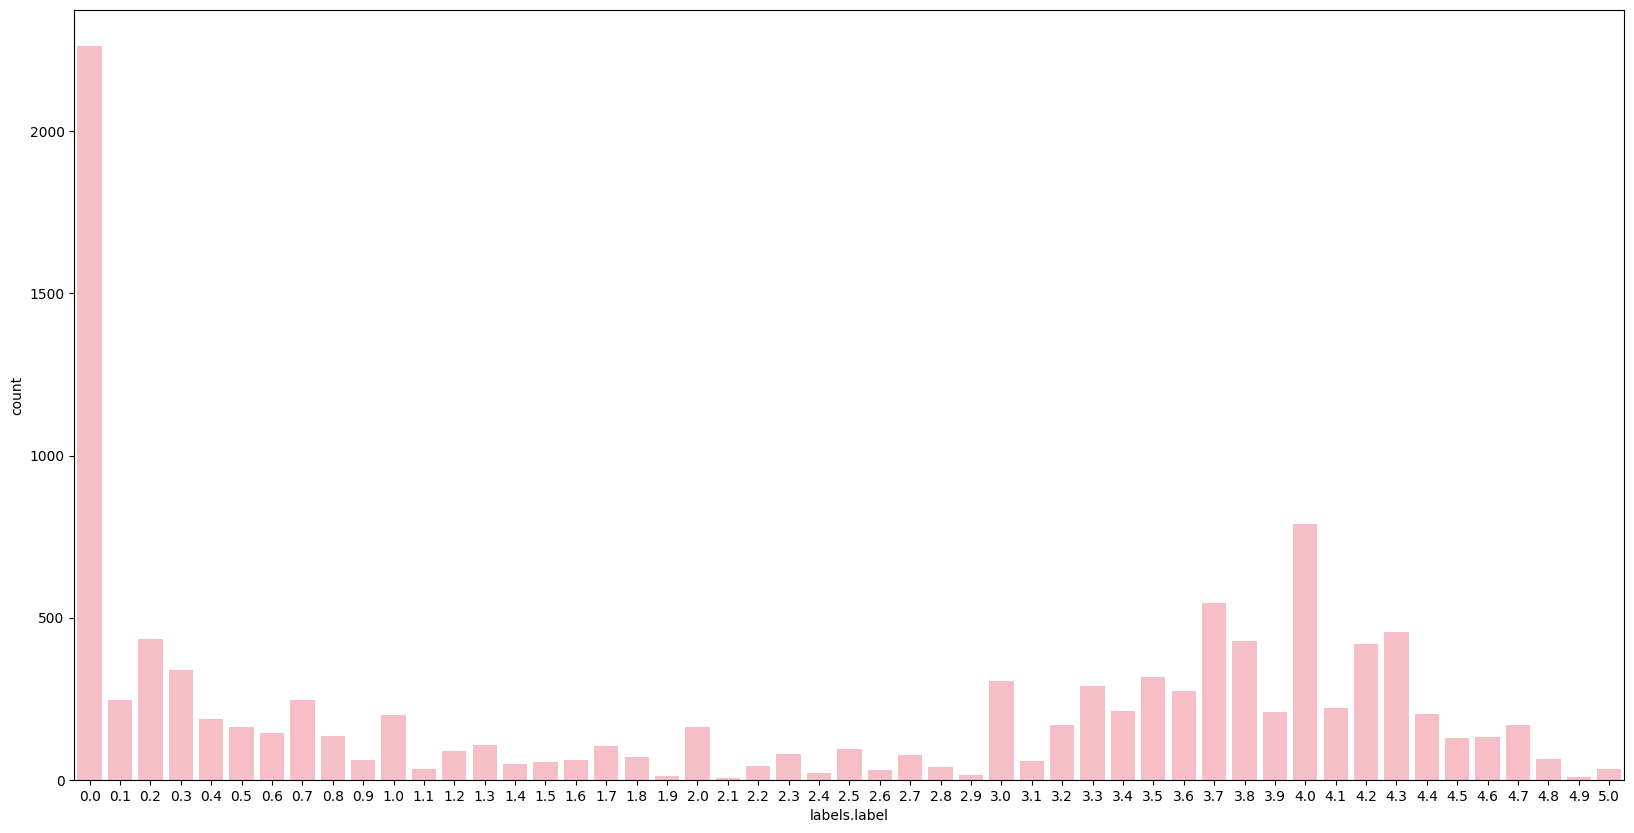

In [30]:
# trainset 분포 확인 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(20,10))


sns.countplot(x = train['labels.label'],color='#FFB6C2')


plt.show()

### Data Augmentation

* korsts test 와 exobrain paraKAIST데이터 추가 

In [31]:
#korsts testset 의 데이터 추가
aug_korsts = pd.read_csv('/home/sol3sts/dataset/aug_korsts.csv')
aug_korsts = aug_korsts[aug_korsts['source'] == 'korsts_test']
aug_korsts = aug_korsts[['sentence1','sentence2','labels.label']]
aug_korsts = aug_korsts[(aug_korsts['labels.label'] >=1.8) & (aug_korsts['labels.label'] <=3.2)]

aug_korsts

,sentence1,sentence2,labels.label
2523,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.,2.5
2524,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.,2.5
2525,한 남자가 자전거를 타고 있다.,한 남자가 말하고 있다.,2.8
2526,한 남자가 양파를 자르고 있다.,한 여성이 호박을 썰고 있다.,2.6
2527,한 남자가 말하고 있다.,한 남자가 요리를 하고 있다.,2.6
...,...,...,...
3003,텍사스 공장 폭발로 100명 이상이 부상당했다.,수백 명의 사람들이 텍사스 비료 공장 폭발로 부상당한 것으로 추정된다.,2.9
3004,보도에 따르면 남한 군인은 북한과의 국경에서 5명의 동지들을 살해한 후 도망친다고 한다.,남한 군인이 동지들을 죽이고 도망친다.,2.6
3005,아프가니스탄의 무장 공격으로 상부에서 4명이 사망했다.,아프가니스탄의 무장 공격으로 발로치스탄에서 FC 병사가 사망했다.,2.6
3006,아프가니스탄 테러로 13명 사망,아프가니스탄 수도 모스크 공격으로 6명 사망,3.2


In [32]:
# paraKAIST 추가 

aug_paraKAIST = pd.read_csv('/home/sol3sts/dataset/aug_paraKAIST.csv')
aug_paraKAIST = aug_paraKAIST[['sentence1','sentence2','labels.label']]
print(logging.info("aumentation없는 모델로 라벨한 paraKAIST "))
aug_paraKAIST

2022-12-20 18:39:38 - aumentation없는 모델로 라벨한 paraKAIST 
None


,sentence1,sentence2,labels.label
0,홍선주는 21일 자신의 페이스북에 '뉴스룸' 인터뷰를 한 사람이 자신이라고 공개했다.,"홍선주는 21일 자신의 페이스북에 ""접니다. JTBC '뉴스룸' 손석희 씨와 전화 ...",2.9
1,다음은 이윤택 전 연희단거리패 예술감독의 사과문 전문이다.,다음은 이윤택 전 예술감독이 밝힌 사과문 전문과 1문 1답 전문이다.,3.2
2,9일 강원도 평창올림픽스타디움에서 열린 평창동계패럴림픽 개막식에서 문재인 대통령이 ...,9일 강원도 평창 올림픽스타디움에서 2018 평창 동계패럴림픽 개회식이 열리고 있다.,3.1
3,사람들을 만나기에 좋은 날이에요.,대인운이 좋으니 사람을 만나기에 좋은 날입니다.,3.0
4,나도 당했다) 폭로를 통해 뒤늦게 알려졌다.,나도 당했다) 폭로가 이어지고 있다.,2.8
...,...,...,...
361,꺼림칙한 사람이나 불필요한 자리는 피하도록 하세요.,되도록 많은 사람들이 모이는 자리에 빠지지 않도록 하세요.,2.1
362,내키지 않는 모임도 피하도록 하세요.,지나친 고집은 피하도록 하세요.,2.0
363,낙동강물을 사용하면 원수 대금뿐만 아니라 물이용 부담금을 따로 내야 한다.,원수 대금과 물이용 부담금도 없었다.,2.3
364,평창패럴림픽 개막일인 9일 오전 강원 평창군 일대에 긴급 제설작전이 펼쳐졌다.,2018 평창동계패럴림픽 개막일인 9일 오전 강원도 평창 바이애슬론센터에서 선수들이...,2.2


In [33]:
# data augmentation: korsts_1.8-3.2 trainset에추가 

train = pd.concat([train,aug_korsts,aug_paraKAIST])
train = train.reset_index()
len(train),len(val),len(test)

(11843, 638, 557)

In [34]:
len(train[(train['labels.label'] >= 1.8) & (train['labels.label'] <= 3.2)])

2031

### 모델 입력 형태로 바꿔주기

* 1.8-3.2구간의 추가된 분포 확인 

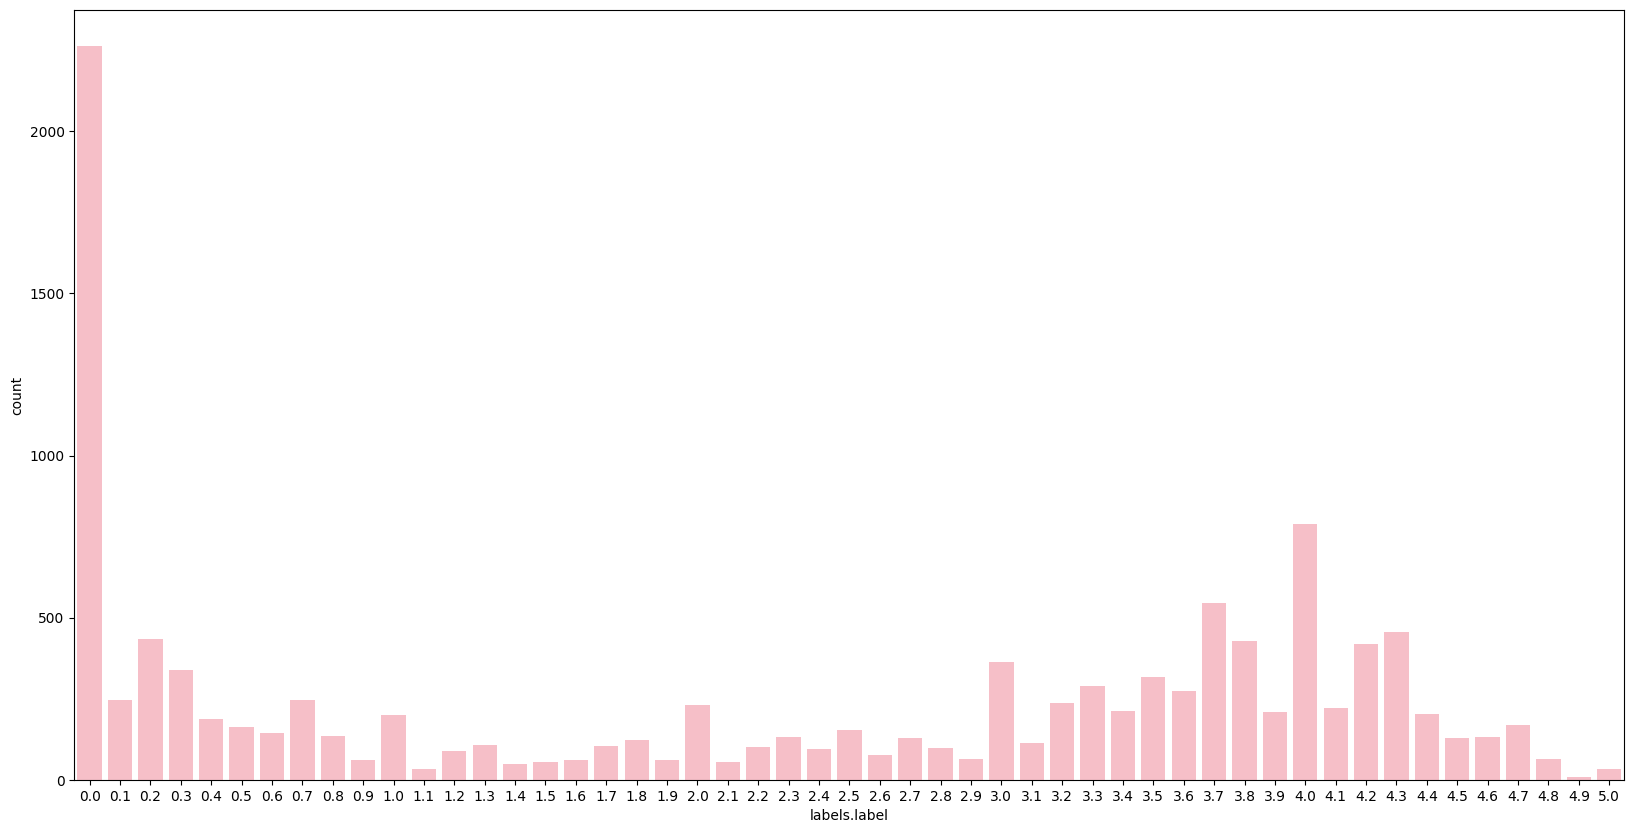

In [35]:
# trainset 분포 확인 
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(20,10))


sns.countplot(x = train['labels.label'],color='#FFB6C2')


plt.show()

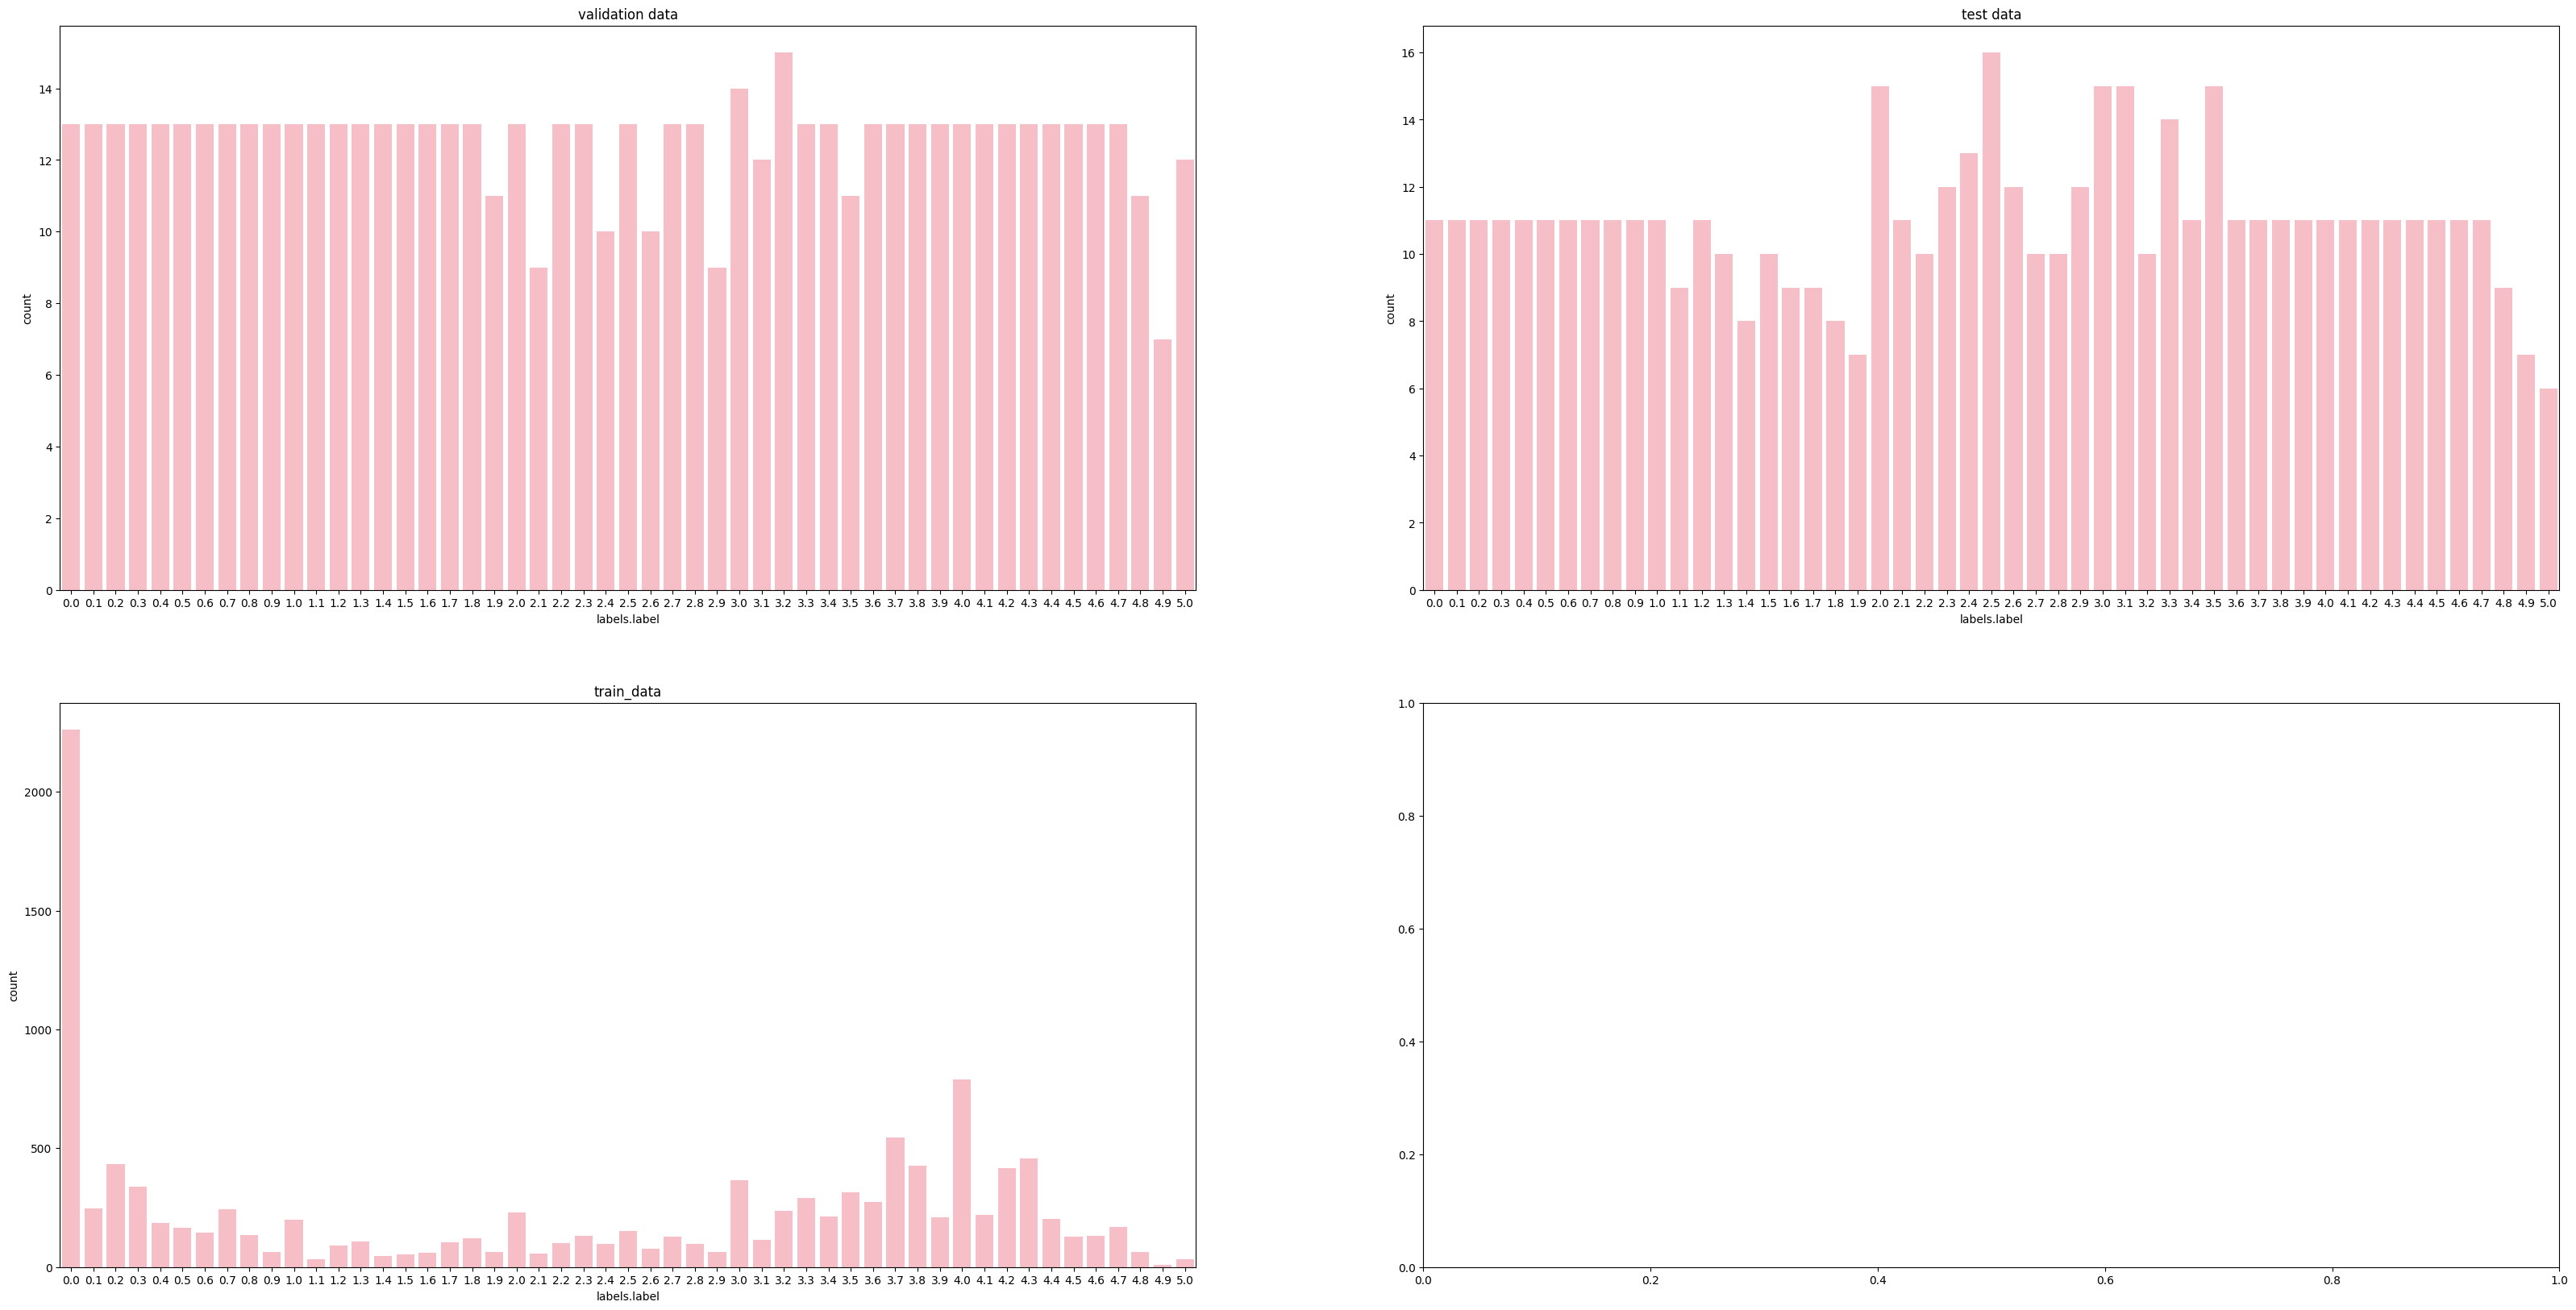

In [37]:
# 전체셋 분포 확인 
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(40,20))


sns.countplot(x = val['labels.label'],ax=ax[0,0],color='#FFB6C1')
sns.countplot(x = test['labels.label'],ax=ax[0,1],color='#FFB6C1')
sns.countplot(x = train['labels.label'],ax=ax[1,0],color='#FFB6C1')

ax[0,0].set_title("validation data")
ax[0,1].set_title("test data")
ax[1,0].set_title('train_data')

plt.show()

In [38]:
len(train),len(val),len(test)

(11843, 638, 557)

In [39]:
train = train.reset_index()
train = train[['sentence1','sentence2','labels.label']]
val = val[['sentence1','sentence2','labels.label']]
test = test[['sentence1','sentence2','labels.label']]

In [40]:
# 모델에 입력형태로 바꿔주기 (train, val, test)

input_examples_train=[]
for i in tqdm(range(len(train))):
  sentence1 = train.values[i][0]
  sentence2 = train.values[i][1]
  score = train.values[i][2]/5.0 # 0-1사이로 정규화 
  input_examples_train.append(InputExample(texts=[sentence1, sentence2], label=score))

input_examples_val=[]
for i in tqdm(range(len(val))):
  sentence1 = val.values[i][0]
  sentence2 = val.values[i][1]
  score = val.values[i][2]/5.0
  input_examples_val.append(InputExample(texts=[sentence1, sentence2], label=score))

input_examples_test=[]
for i in tqdm(range(len(test))):
  sentence1 = test.values[i][0]
  sentence2 = test.values[i][1]
  score = test.values[i][2]/5.0
  input_examples_test.append(InputExample(texts=[sentence1, sentence2], label=score))

  0%|          | 0/11843 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

In [41]:
sts_train_examples = input_examples_train
sts_val_examples = input_examples_val
sts_test_examples = input_examples_test

In [42]:
sts_val_examples[0].texts, sts_val_examples[0].label

(['다음에 도쿄를 또 간다면 무조건 이 곳을 다시 찾을 겁니다.', '독일을 다음에 또간다면 이숙소에 머물겁니다.'], 0.5)

In [43]:
len(input_examples_train), len(input_examples_val), len(input_examples_test)

(11843, 638, 557)

### Evaluator 정의 (cross encoder)

In [44]:
## CROSS-ENCODER ##
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator


# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size, 
)

# Evaluator CEcorrelationEvaluator
logging.info("Creating cross-encoder evaluators")
val_evaluator = CECorrelationEvaluator.from_input_examples(
    sts_val_examples,
    name="sts-cross_encoder-val",
)


#Evaluator by sts-test
test_evaluator = CECorrelationEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-cross_encoder-test",
)

2022-12-20 18:42:18 - Creating cross-encoder evaluators


###  training

In [45]:
! nvidia-smi

Tue Dec 20 18:42:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.88       Driver Version: 418.88       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        On   | 00000000:3B:00.0 Off |                  N/A |
| 46%   31C    P8     5W / 105W |     11MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P4000        On   | 00000000:D8:00.0 Off |                  N/A |
| 46%   33C    P8     5W / 105W |    950MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [46]:
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# Current cuda device:  0


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [48]:
## CROSS-ENCODER ## 


# linear learning-rate warmup steps
warmup_steps = math.ceil(len(train_dataloader) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps)) # 학습 로그 표시 



# Training
cross_encoder.fit(
    train_dataloader = train_dataloader,
    evaluator=val_evaluator,
    epochs=num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    optimizer_params = {'lr':5e-5},
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    show_progress_bar = True
)

2022-12-20 18:42:26 - Warmup-steps: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/371 [00:00<?, ?it/s]

Iteration:   0%|          | 0/371 [00:00<?, ?it/s]

Iteration:   0%|          | 0/371 [00:00<?, ?it/s]

In [49]:
model_save_path 

'/home/sol3sts/removed_mean_cross_encoder_-2022-12-20_18-35-15'

### cross-encoder-test_evaluating

In [50]:
# test 
cross_encoder = CrossEncoder(model_save_path)
test_evaluator(cross_encoder)

0.917712439005509

#### bin 별로 성능평가 

In [51]:
pairs_all = list(zip(test['sentence1'], test['sentence2']))

scores_all = cross_encoder.predict(pairs_all,
                               show_progress_bar = True)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [52]:
test['silver_label'] = np.round((scores_all * 5).tolist(), 1)
# test['silver_label'] = (scores_all * 5).tolist()
test

,sentence1,sentence2,labels.label,silver_label
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.9,4.4
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.4,1.7
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.3,1.3
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.7,3.8
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,3.0,2.6
...,...,...,...,...
552,전자레인지말고 가스레인지를 쓰면 어떄?,믹서기 말고 가스레인지를 써보는 건 어때?,2.7,3.2
553,드럼 세탁기랑 통돌이 세탁기 세척력 비교해봐,드럼이랑 통돌이랑 세척력 좋은 것 부터 알려줘,3.4,3.6
554,깨끗하고 호스트의 배려가 돋보이는 숙소입니다.,그 외에는 호스트의 배려가 돋보이는 숙소였습니다.,3.4,3.1
555,"에어비앤비 광고메일이 더 많아, 트립 닷컴 메일이 더 많아?",에어비앤비랑 트립닷컴 중 누가 더 메일을 많이 보내?,3.4,3.5


In [53]:
print("'Spearman correlation' for whole test data:",test.corr(method='spearman')['silver_label'][0])
print("'Pearson correlation' for whole test data:",test.corr(method='pearson')['silver_label'][0])

'Spearman correlation' for whole test data: 0.9176810393251967
'Pearson correlation' for whole test data: 0.9153226522280032


In [54]:
## 1.8 - 3.2구간만 따로 테스트 / 해당구간의 성능변화가 데이터증강에 따라 유의미한지 판단 
target_test = test[(test['labels.label'] >=1.8) & (test['labels.label'] <=3.2)]

print("'Spearman correlation' for whole test data:",target_test.corr(method='spearman')['silver_label'][0])
print("'Pearson correlation' for whole test data:",target_test.corr(method='pearson')['silver_label'][0])

'Spearman correlation' for whole test data: 0.4509371050199718
'Pearson correlation' for whole test data: 0.4475556054451484


In [55]:
correct=[]
for i in range(len(test)):
  if (test['silver_label'].values[i] >= 3.0) & (test['labels.label'].values[i] >= 3.0):
    correct.append('True_P')
  elif (test['silver_label'].values[i] < 3.0) & (test['labels.label'].values[i] < 3.0):
    correct.append('True_N')
  elif (test['silver_label'].values[i] >= 3.0) & (test['labels.label'].values[i] < 3.0):
    correct.append('False_P')
  else:
    correct.append('False_N')



In [56]:
test['correctness'] = correct

print("whole test data confusion matrix")
print()
print(test['correctness'].value_counts())

whole test data confusion matrix

True_N     265
True_P     213
False_P     58
False_N     21
Name: correctness, dtype: int64


In [57]:
# acc / f1 
TP = len(test[test['correctness'] == 'True_P'])
TN = len(test[test['correctness'] == 'True_N'])
FP = len(test[test['correctness'] == 'False_P'])
FN = len(test[test['correctness'] == 'False_N'])

print("precision", TP/(TP+FP))
print("recall", TP/(TP+FN))
pc=TP/(TP+FP)
rc=TP/(TP+FN)
print("f1 score", 2*pc*rc/(pc+rc))

precision 0.7859778597785978
recall 0.9102564102564102
f1 score 0.8435643564356435


0.5단위 bin 만들기

In [58]:
# train
t = []
for i in range(len(train)):
  if (train['labels.label'].values[i] >= 0.0)  & (train['labels.label'].values[i] <=0.2):
    t.append(0.0)
  elif (train['labels.label'].values[i] >= 0.2)  & (train['labels.label'].values[i] <=0.7):
    t.append(0.5)  
  elif (train['labels.label'].values[i] >= 0.8)  & (train['labels.label'].values[i] <=1.2):
    t.append(1.0)
  elif (train['labels.label'].values[i] >= 1.3)  & (train['labels.label'].values[i] <=1.7):
    t.append(1.5)  
  elif (train['labels.label'].values[i] >= 1.8)  & (train['labels.label'].values[i] <=2.2):
    t.append(2.0)
  elif (train['labels.label'].values[i] >= 2.3)  & (train['labels.label'].values[i] <=2.7):
    t.append(2.5)  
  elif (train['labels.label'].values[i] >= 2.8)  & (train['labels.label'].values[i] <=3.2):
    t.append(3.0)
  elif (train['labels.label'].values[i] >= 3.3)  & (train['labels.label'].values[i] <=3.7):
    t.append(3.5)  
  elif (train['labels.label'].values[i] >= 3.8)  & (train['labels.label'].values[i] <=4.2):
    t.append(4.0)
  elif (train['labels.label'].values[i] >= 4.3)  & (train['labels.label'].values[i] <=4.7):
    t.append(4.5)  
  elif (train['labels.label'].values[i] >= 4.8)  & (train['labels.label'].values[i] <=5.0):
    t.append(5.0)


print(len(t))

train['gold_bin'] = t


train_bin_05 = train[train['gold_bin'] == 0.5]
train_bin_10 = train[train['gold_bin'] == 1.0]
train_bin_15 = train[train['gold_bin'] == 1.5]
train_bin_20 = train[train['gold_bin'] == 2.0]
train_bin_25 = train[train['gold_bin'] == 2.5]
train_bin_30 = train[train['gold_bin'] == 3.0]
train_bin_35 = train[train['gold_bin'] == 3.5]
train_bin_40 = train[train['gold_bin'] == 4.0]
train_bin_45 = train[train['gold_bin'] == 4.5]
train_bin_50 = train[train['gold_bin'] == 5.0]



11843


In [59]:
# test
a = []
for i in range(len(test)):
  if (test['labels.label'].values[i] >= 0.0)  & (test['labels.label'].values[i] <=0.2):
    a.append(0.0)
  elif (test['labels.label'].values[i] >= 0.2)  & (test['labels.label'].values[i] <=0.7):
    a.append(0.5)  
  elif (test['labels.label'].values[i] >= 0.8)  & (test['labels.label'].values[i] <=1.2):
    a.append(1.0)
  elif (test['labels.label'].values[i] >= 1.3)  & (test['labels.label'].values[i] <=1.7):
    a.append(1.5)  
  elif (test['labels.label'].values[i] >= 1.8)  & (test['labels.label'].values[i] <=2.2):
    a.append(2.0)
  elif (test['labels.label'].values[i] >= 2.3)  & (test['labels.label'].values[i] <=2.7):
    a.append(2.5)  
  elif (test['labels.label'].values[i] >= 2.8)  & (test['labels.label'].values[i] <=3.2):
    a.append(3.0)
  elif (test['labels.label'].values[i] >= 3.3)  & (test['labels.label'].values[i] <=3.7):
    a.append(3.5)  
  elif (test['labels.label'].values[i] >= 3.8)  & (test['labels.label'].values[i] <=4.2):
    a.append(4.0)
  elif (test['labels.label'].values[i] >= 4.3)  & (test['labels.label'].values[i] <=4.7):
    a.append(4.5)  
  elif (test['labels.label'].values[i] >= 4.8)  & (test['labels.label'].values[i] <=5.0):
    a.append(5.0)

b = []
for i in range(len(test)):
  if (test['silver_label'].values[i] >= 0.0)  & (test['silver_label'].values[i] <=0.2):
    b.append(0.0)
  elif (test['silver_label'].values[i] >= 0.3)  & (test['silver_label'].values[i] <=0.7):
    b.append(0.5)  
  elif (test['silver_label'].values[i] >= 0.8)  & (test['silver_label'].values[i] <=1.2):
    b.append(1.0)
  elif (test['silver_label'].values[i] >= 1.3)  & (test['silver_label'].values[i] <=1.7):
    b.append(1.5)  
  elif (test['silver_label'].values[i] >= 1.8)  & (test['silver_label'].values[i] <=2.2):
    b.append(2.0)
  elif (test['silver_label'].values[i] >= 2.3)  & (test['silver_label'].values[i] <=2.7):
    b.append(2.5)  
  elif (test['silver_label'].values[i] >= 2.8)  & (test['silver_label'].values[i] <=3.2):
    b.append(3.0)
  elif (test['silver_label'].values[i] >= 3.3)  & (test['silver_label'].values[i] <=3.7):
    b.append(3.5)  
  elif (test['silver_label'].values[i] >= 3.8)  & (test['silver_label'].values[i] <=4.2):
    b.append(4.0)
  elif (test['silver_label'].values[i] >= 4.3)  & (test['silver_label'].values[i] <=4.7):
    b.append(4.5)  
  elif (test['silver_label'].values[i] >= 4.8)  & (test['silver_label'].values[i] <=5.0):
    b.append(5.0)

len(a), len(b)

(557, 557)

In [60]:

#test

test['differ']= np.round(test['labels.label'] - test['silver_label'],1)
test['gold_bin'] = a
test['silver_bin'] = b

test['same_bin']= (test['gold_bin'] == test['silver_bin'])

# bin간의 거리
test['bin_distance'] = test['gold_bin'] - test['silver_bin']


#MSE
test['SE'] = test['differ']**2 
print("MSE:",sum(test['SE']) / len(test)) 

# make bin
bin_05 = test[test['gold_bin'] == 0.5]
bin_10 = test[test['gold_bin'] == 1.0]
bin_15 = test[test['gold_bin'] == 1.5]
bin_20 = test[test['gold_bin'] == 2.0]
bin_25 = test[test['gold_bin'] == 2.5]
bin_30 = test[test['gold_bin'] == 3.0]
bin_35 = test[test['gold_bin'] == 3.5]
bin_40 = test[test['gold_bin'] == 4.0]
bin_45 = test[test['gold_bin'] == 4.5]
bin_50 = test[test['gold_bin'] == 5.0]

MSE: 0.33642728904847397


In [61]:
print("Test_Evaluation_Per_Bin")
print( "len = number of test_data,", "ME = mean_error")
print()
print("<bin_0.5>:","pearson:",bin_05.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_05.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_05), "MSE:",round(sum(bin_05['SE']) / len(bin_05),2),"ME:",round(sum(bin_05['differ']) / len(bin_05),2),"len(train):",len(train_bin_05))
print("<bin_1.0>:","pearson:",bin_10.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_10.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_10), "MSE:",round(sum(bin_10['SE']) / len(bin_10),2),"ME:",round(sum(bin_10['differ']) / len(bin_10),2),"len(train):",len(train_bin_10))
print("<bin_1.5>:","pearson:",bin_15.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_15.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_15), "MSE:",round(sum(bin_15['SE']) / len(bin_15),2),"ME:",round(sum(bin_15['differ']) / len(bin_15),2),"len(train):",len(train_bin_15))
print("<bin_2.0>:","pearson:",bin_20.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_20.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_20), "MSE:",round(sum(bin_20['SE']) / len(bin_20),2),"ME:",round(sum(bin_20['differ']) / len(bin_20),2),"len(train):",len(train_bin_20))
print("<bin_2.5>:","pearson:",bin_25.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_25.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_25), "MSE:",round(sum(bin_25['SE']) / len(bin_25),2),"ME:",round(sum(bin_25['differ']) / len(bin_25),2),"len(train):",len(train_bin_25))
print("<bin_3.0>:","pearson:",bin_30.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_30.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_30), "MSE:",round(sum(bin_30['SE']) / len(bin_30),2),"ME:",round(sum(bin_30['differ']) / len(bin_30),2),"len(train):",len(train_bin_30))
print("<bin_3.5>:","pearson:",bin_35.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_35.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_35), "MSE:",round(sum(bin_35['SE']) / len(bin_35),2),"ME:",round(sum(bin_35['differ']) / len(bin_35),2),"len(train):",len(train_bin_35))
print("<bin_4.0>:","pearson:",bin_40.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_40.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_40), "MSE:",round(sum(bin_40['SE']) / len(bin_40),2),"ME:",round(sum(bin_40['differ']) / len(bin_40),2),"len(train):",len(train_bin_40))
print("<bin_4.5>:","pearson:",bin_45.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_45.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_45), "MSE:",round(sum(bin_45['SE']) / len(bin_45),2),"ME:",round(sum(bin_45['differ']) / len(bin_45),2),"len(train):",len(train_bin_45))
print("<bin_5.0>:","pearson:",bin_50.corr(method='pearson')['silver_label'][0].round(2),"spaerman:",bin_50.corr(method='spearman')['silver_label'][0].round(2), "len:",len(bin_50), "MSE:",round(sum(bin_50['SE']) / len(bin_50),2),"ME:",round(sum(bin_50['differ']) / len(bin_50),2),"len(train):",len(train_bin_50))

Test_Evaluation_Per_Bin
len = number of test_data, ME = mean_error

<bin_0.5>: pearson: 0.19 spaerman: 0.15 len: 55 MSE: 0.37 ME: -0.28 len(train): 1079
<bin_1.0>: pearson: 0.01 spaerman: 0.03 len: 53 MSE: 0.39 ME: -0.09 len(train): 520
<bin_1.5>: pearson: 0.28 spaerman: 0.28 len: 46 MSE: 0.37 ME: -0.2 len(train): 374
<bin_2.0>: pearson: 0.04 spaerman: 0.02 len: 51 MSE: 0.54 ME: -0.31 len(train): 569
<bin_2.5>: pearson: 0.3 spaerman: 0.3 len: 63 MSE: 0.43 ME: -0.36 len(train): 585
<bin_3.0>: pearson: -0.31 spaerman: -0.24 len: 62 MSE: 0.45 ME: -0.15 len(train): 877
<bin_3.5>: pearson: 0.31 spaerman: 0.31 len: 62 MSE: 0.12 ME: 0.02 len(train): 1638
<bin_4.0>: pearson: 0.31 spaerman: 0.36 len: 55 MSE: 0.16 ME: 0.23 len(train): 2063
<bin_4.5>: pearson: 0.21 spaerman: 0.2 len: 55 MSE: 0.32 ME: 0.47 len(train): 1090
<bin_5.0>: pearson: 0.51 spaerman: 0.56 len: 22 MSE: 0.35 ME: 0.56 len(train): 104


In [62]:
# Confusion matrix

# acc / f1

def confusion_matrix(test):

  TP = len(test[test['correctness'] == 'True_P'])
  TN = len(test[test['correctness'] == 'True_N'])
  FP = len(test[test['correctness'] == 'False_P'])
  FN = len(test[test['correctness'] == 'False_N'])
  print("TP:",TP,"TN:",TN,"FP:",FP,"FN",FN)

  
  if (TP + FP) & (TP+FN) ==0:
    return("accuracy:",(TP+TN)/(TP+TN+FP+FN))
  
  else:
    pc=TP/(TP+FP)
    rc=TP/(TP+FN)
    
    return("accuracy:",(TP+TN)/(TP+TN+FP+FN),"precision:", TP/(TP+FP), "recall:", TP/(TP+FN),"f1 score:", 2*pc*rc/(pc+rc))

print("전체 test data")
print()
print("TP = 유사한페어를 유사하다고 정답,", "TN = 유사하지않은 페어를 유사하지 않다고 정답,", "FP=유사하지 않은페어를 유사하다고 오판,", "FN = 유사한페어를 유사하지않다고 오판")
print()
print("1.3-1.7:")
print(confusion_matrix(bin_15))
print()
print("1.8-2.2:")
print(confusion_matrix(bin_20))
print()
print("2.3-2.7:")
print(confusion_matrix(bin_25))
print()
print("2.8-3.2:")
print(confusion_matrix(bin_30))
print()
print("3.3-3.7:")
print(confusion_matrix(bin_35))
print()
print("3.8-4.2:")
print(confusion_matrix(bin_40))
print()
print("4.3-4.7:")
print(confusion_matrix(bin_45))
print()
print("4.8-5.0:")
print(confusion_matrix(bin_50))

전체 test data

TP = 유사한페어를 유사하다고 정답, TN = 유사하지않은 페어를 유사하지 않다고 정답, FP=유사하지 않은페어를 유사하다고 오판, FN = 유사한페어를 유사하지않다고 오판

1.3-1.7:
TP: 0 TN: 44 FP: 2 FN 0
('accuracy:', 0.9565217391304348)

1.8-2.2:
TP: 0 TN: 41 FP: 10 FN 0
('accuracy:', 0.803921568627451)

2.3-2.7:
TP: 0 TN: 35 FP: 28 FN 0
('accuracy:', 0.5555555555555556)

2.8-3.2:
TP: 27 TN: 4 FP: 18 FN 13
('accuracy:', 0.5, 'precision:', 0.6, 'recall:', 0.675, 'f1 score:', 0.6352941176470589)

3.3-3.7:
TP: 56 TN: 0 FP: 0 FN 6
('accuracy:', 0.9032258064516129, 'precision:', 1.0, 'recall:', 0.9032258064516129, 'f1 score:', 0.9491525423728813)

3.8-4.2:
TP: 54 TN: 0 FP: 0 FN 1
('accuracy:', 0.9818181818181818, 'precision:', 1.0, 'recall:', 0.9818181818181818, 'f1 score:', 0.9908256880733944)

4.3-4.7:
TP: 54 TN: 0 FP: 0 FN 1
('accuracy:', 0.9818181818181818, 'precision:', 1.0, 'recall:', 0.9818181818181818, 'f1 score:', 0.9908256880733944)

4.8-5.0:
TP: 22 TN: 0 FP: 0 FN 0
('accuracy:', 1.0, 'precision:', 1.0, 'recall:', 1.0, 'f1 score:', 1.0)

In [63]:
# 1.8-3.2구간의 confusion matrix 따로 계산하여 false 개수 변화 측정  

FP_1 = len(bin_20[bin_20['correctness'] == 'False_P'])
FN_1 = len(bin_20[bin_20['correctness'] == 'False_N'])
FP_2 = len(bin_25[bin_25['correctness'] == 'False_P'])
FN_2 = len(bin_25[bin_25['correctness'] == 'False_N'])
FP_3 = len(bin_30[bin_30['correctness'] == 'False_P'])
FN_3 = len(bin_30[bin_30['correctness'] == 'False_N'])

FP_1 + FP_2 + FP_3 + FN_1 + FN_2 + FN_3

69